In [9]:
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import torch

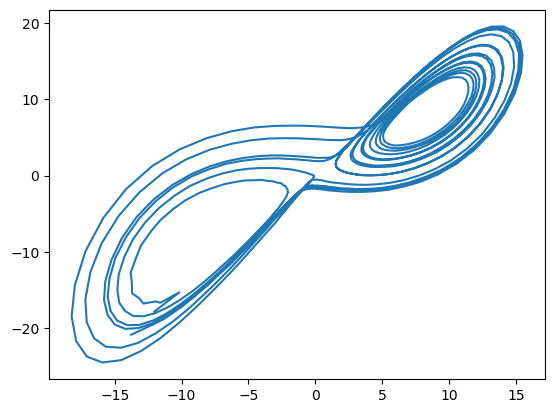

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True,noise=0.01)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])


In [4]:
#try official implementation of s4?
import sys
sys.path.append("/Users/mitchellostrow/Desktop/Projects/NN_delays/s4")
from models.s4.s4 import S4Block as S4  # Can use full version instead of minimal S4D standalone below
from models.s4.s4d import S4D


/Users/mitchellostrow/Desktop/Projects/NN_delays/s4/models/s4/s4.py:155: SyntaxWarning: invalid escape sequence '\s'
  """
/Users/mitchellostrow/Desktop/Projects/NN_delays/s4/models/s4/s4.py:167: SyntaxWarning: invalid escape sequence '\s'
  """
/Users/mitchellostrow/opt/anaconda3/envs/nn_delays/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [118]:
class OfficialS4Minimal(nn.Module):
    def __init__(self,d_input,d_output,d_model,d_state,dropout=0.0,prenorm=False,diagonal=True):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input,d_model)
        s4 = S4 if not diagonal else S4D

        self.s4 = s4(d_model,d_state=d_state,dropout=dropout)

        self.decoder = nn.Linear(d_model,d_output)
        self.norm = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model,4*d_model),
            nn.ReLU(),
            nn.Linear(4*d_model,d_model)
        )

    def forward(self,x):
        # x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)

        z = x
        if self.prenorm:
            # Prenorm
            z = self.norm(z.transpose(-1, -2)).transpose(-1, -2)

        # Apply S4 block: we ignore the state input and output
        z, _ = self.s4(z)

        self.hiddens = z.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)

        # Residual connection
        x = z #+ x

        if not self.prenorm:
            # Postnorm
            x = self.norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x, None




In [119]:
model = OfficialS4Minimal(1,1,100,1000)

torch.Size([1, 1000, 1])
torch.Size([1, 1000, 1]) (1000, 100)


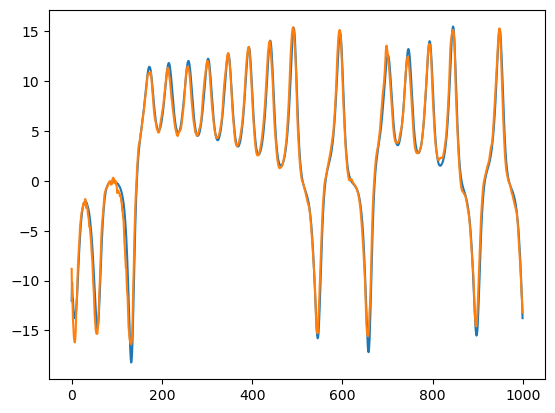

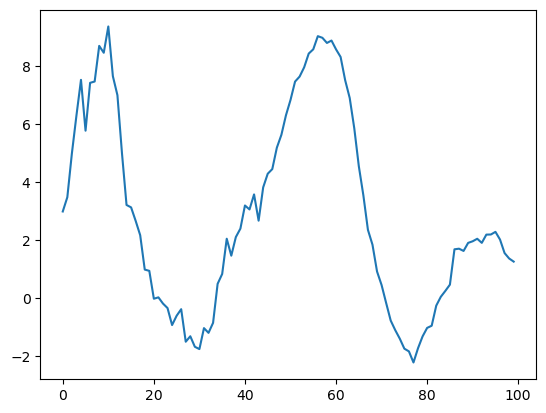

In [128]:
data = torch.tensor(sol[np.newaxis,:,:1]).float()
print(data.size())
plt.figure()
plt.plot(data[0,:,0])


out,_ = model(data)
hidden = model.hiddens.detach().numpy().squeeze()
print(out.shape, hidden.shape)
plt.plot(out.detach().numpy()[0,:,0])

plt.figure()
plt.plot(hidden[:100,0])

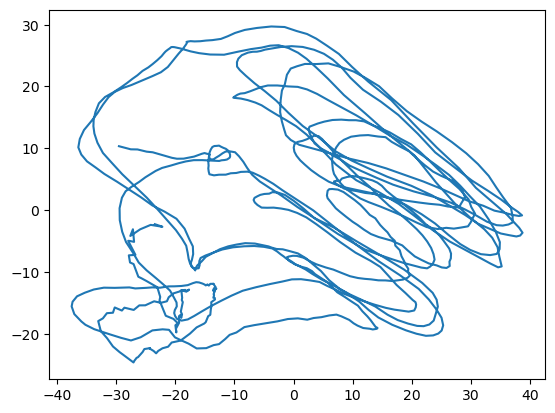

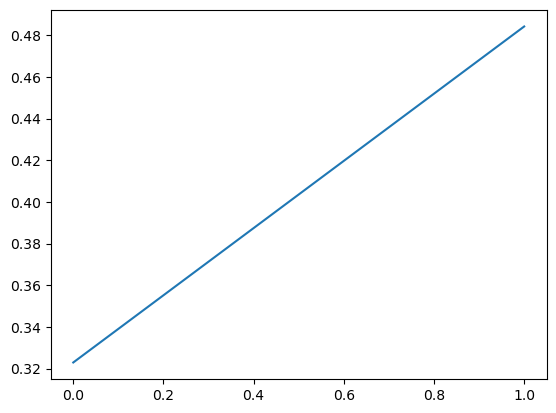

In [95]:
#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [130]:
from utils import make_dataset,train
from torch.optim import AdamW

model = OfficialS4Minimal(1,1,100,1000,dropout=0.1,prenorm=False,diagonal=True)

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,1000,100)

#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), 'cpu')
plt.plot(train_loss)
plt.plot(val_loss)

(100, 1000, 3) torch.Size([100, 1000, 1])
(100, 1000, 3) torch.Size([100, 1000, 1])


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Training Loss: 16.911431465148926


  2%|▏         | 1/50 [00:41<33:45, 41.33s/it]

Epoch 0 Validation Loss: 4.276077311038971
Epoch 1 Training Loss: 3.1136709809303285


  4%|▍         | 2/50 [01:24<34:05, 42.62s/it]

Epoch 1 Validation Loss: 1.4928271496295928
Epoch 2 Training Loss: 1.8426586729288101


  6%|▌         | 3/50 [02:07<33:26, 42.69s/it]

Epoch 2 Validation Loss: 1.056510510444641
Epoch 3 Training Loss: 1.2771311295032501


  8%|▊         | 4/50 [02:48<32:12, 42.00s/it]

Epoch 3 Validation Loss: 0.8656608951091767
Epoch 4 Training Loss: 1.0389518773555755


 10%|█         | 5/50 [07:31<1:36:42, 128.95s/it]

Epoch 4 Validation Loss: 0.7482037907838821
Epoch 5 Training Loss: 0.9016382098197937


 12%|█▏        | 6/50 [08:40<1:19:34, 108.51s/it]

Epoch 5 Validation Loss: 0.5043059012293816
Epoch 6 Training Loss: 0.835009129345417


 14%|█▍        | 7/50 [13:17<1:57:15, 163.62s/it]

Epoch 6 Validation Loss: 0.5126184415817261
Epoch 7 Training Loss: 0.8533478245139122


 16%|█▌        | 8/50 [31:00<5:14:57, 449.94s/it]

Epoch 7 Validation Loss: 0.6269441449642181
Epoch 8 Training Loss: 0.7534862357378006


 18%|█▊        | 9/50 [33:59<4:09:27, 365.07s/it]

Epoch 8 Validation Loss: 0.7351006010174751
Epoch 9 Training Loss: 0.6786153256893158


 20%|██        | 10/50 [46:08<5:18:25, 477.65s/it]

Epoch 9 Validation Loss: 0.3371476835012436
Epoch 10 Training Loss: 0.6494960981607437


 22%|██▏       | 11/50 [1:12:42<8:52:34, 819.34s/it]

Epoch 10 Validation Loss: 0.31202037453651427
Epoch 11 Training Loss: 0.5657362547516823


 24%|██▍       | 12/50 [1:13:21<6:08:30, 581.85s/it]

Epoch 11 Validation Loss: 0.3115593992173672
Epoch 12 Training Loss: 0.5601754933595657


 26%|██▌       | 13/50 [1:14:00<4:17:24, 417.42s/it]

Epoch 12 Validation Loss: 0.31384961053729055
Epoch 13 Training Loss: 0.553315277248621


 28%|██▊       | 14/50 [1:14:39<3:01:50, 303.07s/it]

Epoch 13 Validation Loss: 0.3145699468255043
Epoch 14 Training Loss: 0.553234607130289


 30%|███       | 15/50 [1:15:17<2:10:13, 223.24s/it]

Epoch 14 Validation Loss: 0.23676242172718048
Epoch 15 Training Loss: 0.5121317362785339


 32%|███▏      | 16/50 [1:15:56<1:35:04, 167.78s/it]

Epoch 15 Validation Loss: 0.4875018018484116
Epoch 16 Training Loss: 0.46925222903490066


 34%|███▍      | 17/50 [1:16:35<1:10:56, 128.98s/it]

Epoch 16 Validation Loss: 0.26252964973449705
Epoch 17 Training Loss: 0.4794993695616722


 36%|███▌      | 18/50 [1:17:13<54:16, 101.76s/it]  

Epoch 17 Validation Loss: 0.2957678979635239
Epoch 18 Training Loss: 0.5157264371216297


 38%|███▊      | 19/50 [1:18:16<46:30, 90.03s/it] 

Epoch 18 Validation Loss: 0.22281679421663284
Epoch 19 Training Loss: 0.4313801173865795


 40%|████      | 20/50 [1:19:18<40:52, 81.75s/it]

Epoch 19 Validation Loss: 0.18692021682858467
Epoch 20 Training Loss: 0.38764666303992273


 42%|████▏     | 21/50 [1:20:12<35:24, 73.27s/it]

Epoch 20 Validation Loss: 0.1742678713053465
Epoch 21 Training Loss: 0.409437096118927


 44%|████▍     | 22/50 [1:21:00<30:41, 65.76s/it]

Epoch 21 Validation Loss: 0.24077590733766555
Epoch 22 Training Loss: 0.4466488792002201


 46%|████▌     | 23/50 [1:21:49<27:15, 60.58s/it]

Epoch 22 Validation Loss: 0.2621692644804716
Epoch 23 Training Loss: 0.4324811461567879


 48%|████▊     | 24/50 [1:22:39<24:58, 57.62s/it]

Epoch 23 Validation Loss: 0.246948302090168
Epoch 24 Training Loss: 0.39887780606746676


 50%|█████     | 25/50 [1:23:31<23:17, 55.88s/it]

Epoch 24 Validation Loss: 0.26261501491069794


torch.Size([1, 1000, 1])


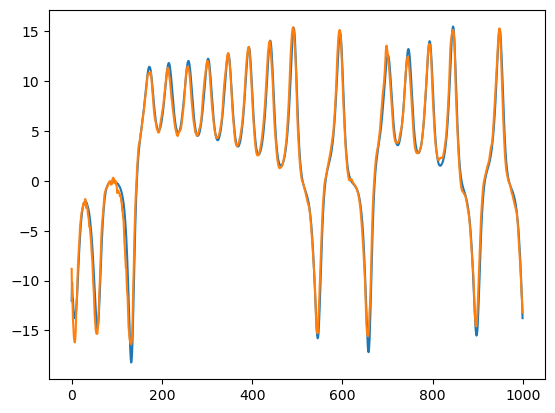

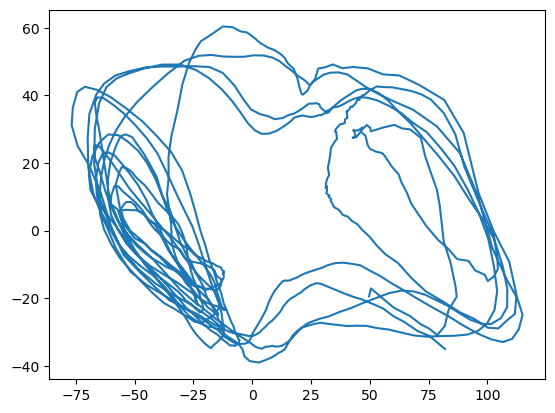

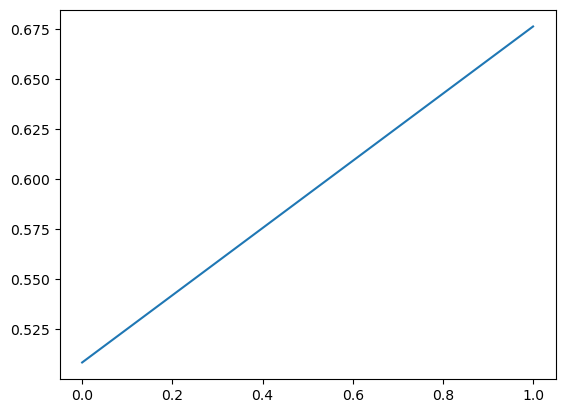

In [ ]:
data = torch.tensor(sol[np.newaxis,:,:1]).float()
print(data.size())
plt.figure()
plt.plot(data[0,:,0])


out,_ = model(data)
hidden = model.hiddens.detach().numpy().squeeze()
out.shape, hidden.shape
plt.plot(out.detach().numpy()[0,:,0])

#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
def hippo_initializer(dim):
    pass

def discretize_dplr(lambd,P,Q,B,C,step,l_max):
    pass

def scan_ssm(ssm,u,x0):
    pass

class minimalS4(nn.Module):
    def __init__(self, input_dim,d_model,n_head):
        super().__init__()

        


In [96]:
import math
from einops import rearrange, repeat

class S4D_rnn(nn.Module):
    #produces the A,B,C,D matrices that recapitulate the s4d kernel below
    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        pass


class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""

    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """

        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

        return K

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

In [108]:
k = S4DKernel(2)
L = 4
self = k

dt = torch.exp(self.log_dt) # (H)
C = torch.view_as_complex(self.C) # (H N)
A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

# Vandermonde multiplication
dtA = A * dt.unsqueeze(-1)  # (H N)
K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
C = C * (torch.exp(dtA)-1.) / A
K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real
K

tensor([[ 0.0005,  0.0215,  0.0420,  0.0594],
        [-0.0892, -0.0363,  0.0305,  0.0749]], grad_fn=<MulBackward0>)